# Data Subsampling Ablation

In [63]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import GraphAE
from parameters import GraphAEParameters, TrainingParameters
from datautils import get_morning_data, get_gcnae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

In [64]:
granularities = {
    '1 minute': 2,
    '2.5 minute': 5,
    '5 minute': 10
}

mins = 5

granularity = granularities[f'{mins} minute']

### Time Series Sequencing

In [65]:
def sequence_gcnae(data, timesteps, hide_anomalies=True):
    sequence = []
    static_edges = generate_edges(milemarkers=list(range(49)))
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times)):
        data_t = []
        contains_anomaly = np.any([np.unique(data[data['unix_time']==t]['anomaly'])[0]])

        if (hide_anomalies and contains_anomaly):
            continue
        
        kept_indices.append(index)

        data_t.append(data[data['unix_time']==t][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not
        
        curr_data = data_t[-1]
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append(curr_graph)

    return sequence, kept_indices

### Loading Hyperparameters

In [66]:
optimal_hyperparams = load_best_parameters('gcn_v2')

In [67]:
optimal_hyperparams

{'dropout': 0.03472588957921531,
 'epochs': 10,
 'gcn_hidden_dim': 64,
 'latent_dim': 128,
 'learning_rate': 0.0004708326073117493,
 'num_gcn': 1,
 'timesteps': 2}

In [68]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [69]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=0,
    n_epochs=1
)

In [70]:
train_data, test_data, _ = get_full_data()
train_data = normalize_data(train_data)
train_data = label_anomalies(train_data)
train_sequence, kept_train_indices = sequence_gcnae(train_data, training_params.timesteps)

100%|██████████| 13440/13440 [00:31<00:00, 432.06it/s]


In [71]:
len(train_sequence)

6436

In [72]:
def subsample(data_sequence, num_downsampling=2):
    return data_sequence[::num_downsampling]

In [73]:
train_sequence = subsample(train_sequence, granularity)

In [74]:
hyperparams = GraphAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_gcn=optimal_hyperparams['num_gcn']
)

In [75]:
ae = GraphAE(hyperparams)

In [76]:
ae(train_sequence[0]).shape

torch.Size([196, 3])

### Model Training or Loading

In [77]:
using_pretrained = True

In [78]:
if not using_pretrained:
    ae, losses = train_gcnae(gcnaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, f'gcn_sub_{granularity}')
else:
    ae = load_model(GraphAE, hyperparams, f'gcn_sub_{granularity}')

In [79]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [80]:
thresh = compute_anomaly_threshold_gcnae(train_sequence, ae, mse_weights, 'max')

100%|██████████| 644/644 [00:01<00:00, 328.77it/s]


### Loading Test Data

In [81]:
_, df_test_data, _ = get_full_data()

In [82]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gcnae(test_data, training_params.timesteps, hide_anomalies=False)
test_data = subsample(test_data, granularity)
unsubsampled_test_indices = kept_test_indices
kept_test_indices = subsample(kept_test_indices, granularity)

100%|██████████| 4800/4800 [00:05<00:00, 954.43it/s]


In [83]:
test_errors, test_recons_speeds, test_true_speeds = test_gcnae(test_data, mse_weights, ae)

In [84]:
np.mean(test_errors)

0.014188912

In [85]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][unsubsampled_test_indices] # need to ensure that this still has the true crash values even though it is subsampled

/home/austinc/projects/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/home/austinc/projects/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [86]:
# Moves crash reports to the next available slice if they would be removed from subsampling
# Uses a conservative estimation that the crash would not be reported until the next available time index
def move_to_slice(arr, step=2):
    result = []
    carry = False  # To carry over a True value to the next slice

    for i in range(0, len(arr), step):
        # Slice the array based on the given step
        slice_ = arr[i:i + step]
        
        if carry:
            result.append(True)
        else:
            result.append(slice_[0])  # Append the first element of the slice
        
        carry = np.any(slice_[1:])  # Set carry to True if there's any True in the remaining part of the slice

    return np.array(result)

In [87]:
crash_reported = move_to_slice(crash_reported, granularity)

### Compute FPR / Crash Detection Delay Tradeoff

In [88]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported, changed_sr=True, sr=mins))

100%|██████████| 1000/1000 [00:06<00:00, 146.98it/s]
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in sca

In [89]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv(f'./saved_results/gcnae_sub__{granularity}_fp_delay.csv')

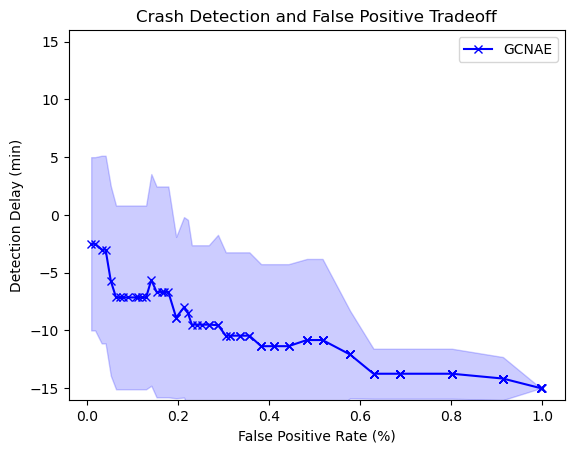

In [90]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] * mins
std_values = delay_df['Std Delay'] * mins

plt.plot(x_values, y_values, color='blue', label='GCNAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [91]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported) 

100%|██████████| 1000/1000 [00:06<00:00, 146.64it/s]

Found FPR of 0.008620689655172414 for 0.01
Found FPR of 0.02586206896551724 for 0.025
Found FPR of 0.04885057471264368 for 0.05
Found FPR of 0.10057471264367816 for 0.1
Found FPR of 0.20114942528735633 for 0.2
FPR 1% gives mean delay of 0.5 +/- 1.224744871391589 while missing 0.75%.
FPR 2.5% gives mean delay of 0.6666666666666666 +/- 5.597618541248888 while missing 0.25%.
FPR 5% gives mean delay of -4.75 +/- 5.226136240091718 while missing 0.16666666666666663%.
FPR 10% gives mean delay of -10.083333333333334 +/- 5.187458165828637 while missing 0.0%.
FPR 20% gives mean delay of -10.708333333333334 +/- 4.875356112349356 while missing 0.0%.


### Compute AUC

In [92]:
calculate_auc(test_errors, anomaly_labels)

0.7181513409961686